In [3]:
import os

import matplotlib.pyplot as plt
import pandas as pd
if os.path.basename(os.path.abspath(".")) == "notebooks":
    os.chdir("..")
from utils import main_setup, AttributeDict
from omegaconf import OmegaConf
from torch import autocast
from src.datasets import get_dataset
from utils import load_model_from_config, collate_batch
from src.visualization.utils import word_to_slice
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch
from src.preliminary_masks import preprocess_attention_maps
from src.visualization.utils import MIMIC_STRING_TO_ATTENTION
import numpy as np
import torchvision
from src.foreground_masks import GMMMaskSuggestor
from src.datasets.mscoco import MultiCaptionDataset
from einops import repeat
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"


MODEL_PATHS = {"sdv2": "/vol/ideadata/ed52egek/diffusionmodels/latentdiffusion/512-base-ema.ckpt", "frozen":"/vol/ideadata/ed52egek/diffusionmodels/chest/miccai_models/frozen_30k.ckpt", "learnable":"/vol/ideadata/ed52egek/diffusionmodels/chest/miccai_models/learnable_60k.ckpt"}

args = AttributeDict(EXP_PATH="src/experiments/default_cfg.py", EXP_NAME="finding_bycicles")
config = main_setup(args)
cxr_dataset = get_dataset(config, "test")

args["EXP_PATH"] = "src/experiments/default_cfg_mscoco.py"
config = main_setup(args)
mscoco_dataset = get_dataset(config, "test")

config.log_dir = os.path.dirname(config.log_dir)
print(f"Saving to {config.log_dir}")

/vol/ideadata/ed52egek/conda/chest/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2023-07-05 10:20:33,043 | utils.py-main_setup-0288 | INFO | Log dir: /vol/ideadata/ed52egek/pycharm/chest-distillation/log/finding_bycicles/2023-07-05T10-20-33
2023-07-05 10:20:33,045 | log.py-log_experiment-0021 | INFO | Args: {'EXP_PATH': 'src/experiments/default_cfg.py', 'EXP_NAME': 'finding_bycicles'}
2023-07-05 10:20:33,047 | log.py-log_experiment-0023 | INFO | Exp Path: src/experiments/default_cfg.py
2023-07-05 10:20:33,114 | utils.py-main_setup-0288 | INFO | Log dir: /vol/ideadata/ed52egek/pycharm/chest-distillation/log/finding_bycicles/2023-07-05T10-20-33
2023-07-05 10:20:33,115 | log.py-log_experiment-0021 | INFO | Args: {'EXP_PATH': 'src/experiments/default_cfg_mscoco.py', 'EXP_NAME': 'finding_bycicles'}
2023-07-05 10:20:33,117 | log.py-log_experiment-0023 | INFO | Exp Path: src/experiments/default_cfg_mscoco.py
2023-07-05 10:20:33,121 | mscoco.py-meta_data-0172 | INFO | Loading image list from /vol/ideadata/ed52egek/data/mscoco/val2017_meta.csv
Saving to /vol/ideadata/ed52eg

In [8]:
from utils import viz_array
model_config = OmegaConf.load(f"{config.config_path}")
models = {k:load_model_from_config(model_config, f"{v}") for k,v in MODEL_PATHS.items()}
device = torch.device("cuda")

mscoco_dataset.load_precomputed(models["sdv2"])
cxr_dataset.load_precomputed(models["sdv2"])

Loading model from /vol/ideadata/ed52egek/diffusionmodels/latentdiffusion/512-base-ema.ckpt
Global Step: 875000
No module 'xformers'. Proceeding without it.
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
Keeping EMAs of 688.
2023-07-05 10:29:47,930 | ddpm.py-__init__-0143 | INFO | Unconditional guidance probability: 0.0
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
2023-07-05 10:29:49,294 | factory.py-create_model-0152 | INFO | Loaded ViT-H-14 model config.
2023-07-05 10:29:57,064 | factory.py-create_model-0199 | INFO | Loading pretrained ViT-H-14 weights (laion2b_s32b_b79k).
Loading model from /vol/ideadata/ed52egek/diffusionmodels/chest/miccai_models/frozen_30k.ckpt
Global Step: 30000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 865.91 M params.
Keeping EMAs of 688.
2023-07-05 10:30:20,921 | ddpm.py-

In [9]:
mscoco_dataset = MultiCaptionDataset(mscoco_dataset)
print(f"MSCOCO dataset keys: {mscoco_dataset[0].keys()};\nMIMIC keys: {cxr_dataset[0].keys()}")

loading annotations into memory...
Done (t=0.57s)
creating index...
index created!
MSCOCO dataset keys: dict_keys(['rel_path', 'finding_labels', 'img_name', 'captions', 'img', 'query_classes']);
MIMIC keys: dict_keys(['dicom_id', 'rel_path', 'finding_labels', 'bboxxywh', 'label_text', 'category_name', 'img_raw', 'img', 'bbox_img'])


In [10]:
def predict(model_name, imgs, captions):
    model = models[model_name]
    precision_scope = autocast
    if isinstance(captions, str):
        captions = [captions,]

    samples = {"img":imgs}

    samples["captions"] = captions
    samples["impression"] = samples["captions"]

    with torch.no_grad():
        with precision_scope("cuda"):
            with model.ema_scope():
                model.cond_stage_model = model.cond_stage_model.to(model.device)
                images = model.log_images(samples, N=len(samples["captions"]), split="test", sample=False,inpaint=True,
                                          plot_progressive_rows=False, plot_diffusion_rows=False,
                                          use_ema_scope=False, cond_key="captions", mask=1., save_attention=True)
                attention_maps = images.pop("attention")
                attention_images = preprocess_attention_maps(attention_maps, on_cpu=False)
    return attention_images




In [11]:
from src.datasets.mscoco import MSCOCO_CLASSES, MultiCaptionDataset
STRING_TO_ATTENTION={l:[l.lower(),] for l in MSCOCO_CLASSES} # in case we want to define multiple words as query words we can add them here


def extract_attention(caption, query_classes, attention_images):
    rev_diff_steps = 40
    assert isinstance(caption, str)
    assert len(attention_images) == 1

    preliminary_attention_masks = {k:[] for k in query_classes}
    for j, attention in enumerate(attention_images):
        tok_attentions = []
        txt_label = caption
        token_lens = models["sdv2"].cond_stage_model.compute_word_len(txt_label.split(" "))
        token_positions = list(np.cumsum(token_lens) + 1)
        token_positions = [1,] + token_positions

        # multiple query classes
        for query_class in query_classes:
            query_words = STRING_TO_ATTENTION[query_class]
            locations = word_to_slice(txt_label.split(" "), query_words)
            if len(locations) == 0:
                # use all
                tok_attention = attention[-1*rev_diff_steps:,:,token_positions[0]:token_positions[-1]]
                tok_attentions.append(tok_attention.mean(dim=(0,1,2)))
            else:
                for location in locations:
                    tok_attention = attention[-1*rev_diff_steps:,:,token_positions[location]:token_positions[location+1]]
                    tok_attentions.append(tok_attention.mean(dim=(0,1,2)))

            preliminary_attention_masks[query_class] = torch.stack(tok_attentions).mean(dim=(0))
    return preliminary_attention_masks



#extract_attention(attention_images)
idx_cxr = 0
idx_msc = 0

img = cxr_dataset[idx_cxr]["img"]
img_raw = cxr_dataset[idx_cxr]["img_raw"]
caption = mscoco_dataset[idx_msc]["captions"]
query_classes = mscoco_dataset[idx_msc]["query_classes"]

attention_images = predict("sdv2", img, caption)
attention_images.size()

print(caption)
print(query_classes)
attention_masks_for_query_class = extract_attention(caption, query_classes, attention_images)


Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
A person in a the reflection of a truck mirror.
['person', 'truck']


2023-07-05 13:58:12,350 | seed.py-seed_everything-0053 | INFO | Global seed set to 10
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
The stop sign has stenciled spray paint on it. 


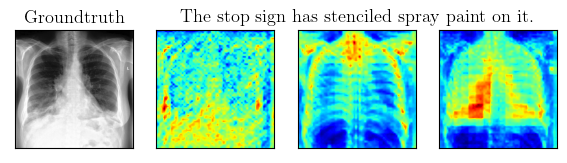

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
A gated grassy noel has a shorted stop sign stuck in part of the land.


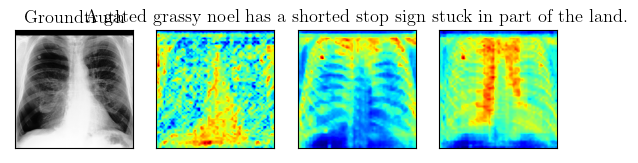

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
A road with California 138 and a stop sign.


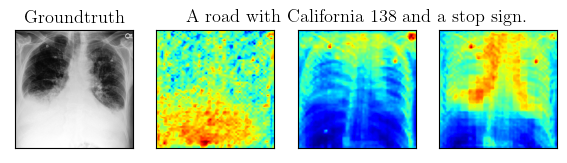

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
A stop sign installed upside down on a street corner


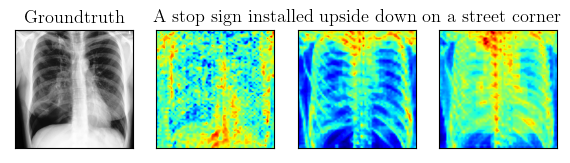

Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
Data shape for DDIM sampling is (1, 4, 64, 64), eta 0.0
an image of a stop sign and yield sign


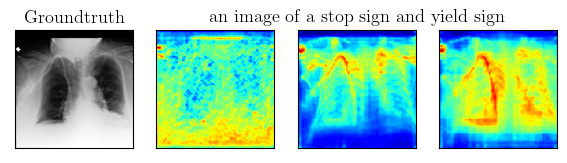

In [16]:
import matplotlib.pyplot as plt
from torchvision.transforms import Resize
from pytorch_lightning import seed_everything
import matplotlib.pyplot as plt
from utils import update_matplotlib_font, set_size

update_matplotlib_font(fontsize=11, fontsize_ticks=8, tex=True)


seed_everything(10)
model_name = "frozen"
idx_cxr = 17

#relevant_classes = ["bird", "person", "dog", "car", "stop sign", "bicycle", "umbrella", "airplane"]
relevant_classes = ["stop sign", ]


for idx_cxr in range(5):
    img = cxr_dataset[idx_cxr]["img"]
    img_raw = cxr_dataset[idx_cxr]["img_raw"]

    for j in range(1):
        query_classes = [""]
        search_for_relevant = True

        while search_for_relevant:
            idx_msc = np.random.randint(len(mscoco_dataset))
            caption = mscoco_dataset[idx_msc]["captions"]
            query_classes = mscoco_dataset[idx_msc]["query_classes"]
            if len(query_classes) == 1:
                for q in query_classes:
                    if q in relevant_classes:
                        search_for_relevant = False


        pred = {"sdv2":[], "learnable":[], "frozen":[]}
        for k, v in pred.items():
            attention_images = predict(k, img, caption)
            attention_images.size()
            attention_masks_for_query_class = extract_attention(caption, query_classes, attention_images)
            pred[k] = attention_masks_for_query_class


        print(caption)
        to_img = Resize(512)
        fig, axs = plt.subplots(1, 4, figsize=set_size("AAAI", fraction=1))
        axs[0].get_yaxis().set_ticks([])
        axs[0].get_xaxis().set_ticks([])

        axs[0].imshow(img_raw.mean(dim=(0,1)), cmap="Greys_r")

        axs[0].set_title("Groundtruth")

        i = 1
        for k, vals in pred.items():
            for _, v in vals.items():
                axs[i].imshow(to_img(v.to("cpu").unsqueeze(dim=0)).squeeze(dim=0), cmap="jet")
            #axs[i].set_title(k)
            axs[i].get_xaxis().set_ticks([])
            axs[i].get_yaxis().set_ticks([])
            i += 1
        axs[2].set_title(caption)
        plt.savefig(os.path.join(config.log_dir, f"{caption}___q_{''.join(query_classes)}.svg"), format='svg', bbox_inches='tight')
        plt.show()

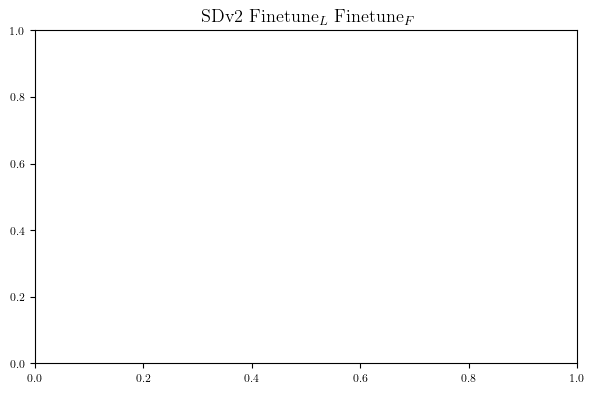

In [15]:
fig, axs = plt.subplots(1, 1, figsize=set_size("AAAI", fraction=1))
axs.set_title("SDv2 Finetune$_L$ Finetune$_F$")
plt.savefig(os.path.join(config.log_dir, f"out.svg"), format='svg', bbox_inches='tight')

torch.Size([77, 64, 64])


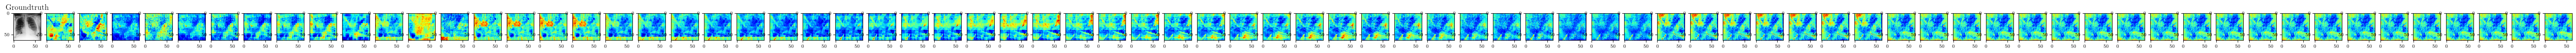

In [7]:
at = attention_images[0, -40:].mean(dim=(0,1))
print(at.size())
fix, axs = plt.subplots(1, 1+len(at), figsize=(77, 4))

axs[0].imshow(to_latent(img_raw).mean(dim=(0,1)), cmap="Greys_r")
axs[0].set_title("Groundtruth")

i = 1
for a in at:
    axs[i].imshow(a.to("cpu"), cmap="jet")
    i += 1
plt.savefig("out.pdf")
plt.show()


In [8]:
os.path.abspath(".")

'/vol/ideadata/ed52egek/pycharm/chest-distillation'

              top1    aucroc       cnr
all       0.718189  0.917614  1.972384
airplane  0.929412  0.975774  2.994303
apple     0.687879  0.887714  1.687015
backpack  0.541667  0.917439  1.777811
banana    0.911778  0.962232  2.237750


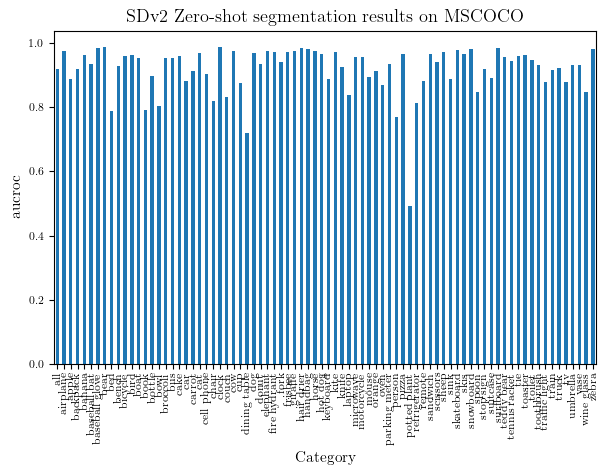

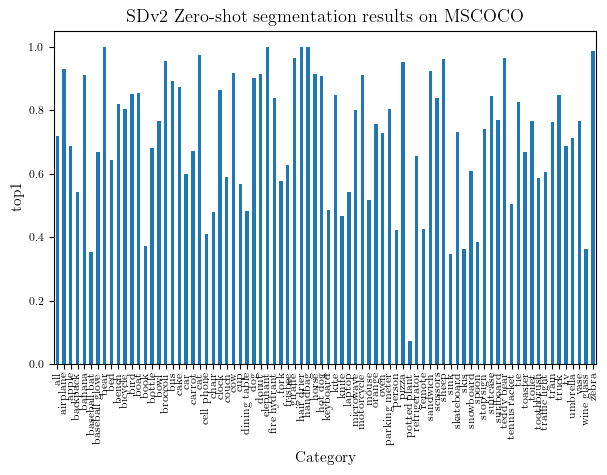

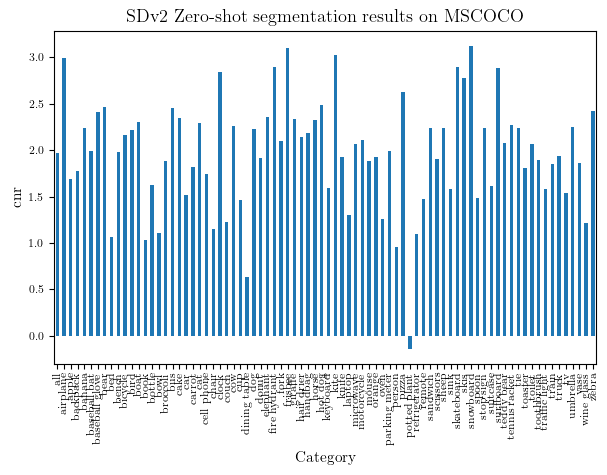

In [7]:
path = "/vol/ideadata/ed52egek/pycharm/chest-distillation/log/mscoco_singlegpu/bbox-sdv2/mscoco_localization_means.json"
import json

import json

with open(path, 'r') as f:
  data = json.load(f)


df = pd.DataFrame.from_dict(data, orient='index')
print(df.head())


for metric in ["aucroc", "top1", "cnr"]:
    df_plot = df.loc[...,[metric,]]
    # Plot the bar plot

    update_matplotlib_font(fontsize=11, fontsize_ticks=8, tex=True)
    fig, ax = plt.subplots(1, 1, figsize=set_size("AAAI", fraction=1))

    df_plot.plot(kind="bar", ax=ax, legend=None)
    ax.set_xlabel("Category")
    ax.set_ylabel(metric)
    ax.set_title("SDv2 Zero-shot segmentation results on MSCOCO")

    # Display the plot
    plt.savefig(os.path.join(config.log_dir, f"{metric}.pdf"), format='pdf', bbox_inches='tight')
    plt.show()